# **Exercise 1: Analyzing Energy Performance of Buildings**

## Overview

In this exercise, we use the publicly available [Energy Performance of Buildings Data](https://epc.opendatacommunities.org/domestic/search) to assess how different factors, such as built form, heating efficiency, and total floor area, affect energy building consumption. By the end of this exercise, you should be able to:
- Process, visualize, and interpret building energy performance data.
- Use descriptive/predictive analytics to identify factors that drive energy consumption.

## Set up

Load the required Python libraries and the data set. The data set contains information from 5000 buildings located in the London borough of Islington and is stored ```...\data raw\epc-certificates-Islington```; file ```certificates.csv``` contains the data and ```columns.csv``` explains the colunm headers. To load the data, update the ```path``` variable to the local folder location. 

For simplicity, columns with ```NaN``` values are dropped. An auxiliary function that estimates predictive accuracy, namely, mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE), is provided.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def accuracy_metrics(actual, predictions):
    ''' Estimate predictive accuracy metrics '''
    actual_copy = actual.copy().reshape(-1,1)
    predictions_copy = predictions.copy().reshape(-1,1)
    
    error = actual_copy - predictions_copy    
    assert(error.shape[0] == len(actual_copy))
    if error.ndim > 1:        
        assert(error.shape[1] == 1)

    mse = np.square(error).mean()
    rmse = np.sqrt( mse )
    mae = np.abs(error).mean()
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    return rmse, mae

# default settings for plots
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,3)

# load data
# !!!! Update the path variable
path = 'C:\\Users\\ucbva19\\Git projects\\energy_analytics_built_env\\data raw\\epc-certificates-Islington'
df = pd.read_csv(f"{path}\\certificates.csv")  # change path

print(df.head())
print(df.isna().sum())

# drop columns with NaNs
df = df.dropna(axis=1)

assert(df.isna().sum().sum() == 0)

                                             LMK_KEY          ADDRESS1  \
0  05a4e13c8f8892b40f457e58195271839c253e738b2a4a...            Flat A   
1  07c0c456133427557a94e545821381d14767982acbf6cb...           Flat 17   
2  09ff1f899a2a4bfa4b183664b5d95962f6f636beba7616...           Flat 13   
3  104aed0a570454905c714411fff45406314dbb0cdcbf92...  144a Hanley Road   
4  117e6ac108ca5cb9de1ac1c4f5c82f526f8a6f7be28bf9...           Flat 16   

                  ADDRESS2            ADDRESS3 POSTCODE  \
0           32 Hanley Road                 NaN   N4 3DR   
1  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
2  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
3                      NaN                 NaN   N4 3DW   
4  Park Gate House 250-252  Seven Sisters Road   N4 2HU   

   BUILDING_REFERENCE_NUMBER CURRENT_ENERGY_RATING POTENTIAL_ENERGY_RATING  \
0                10008499045                     D                       C   
1                10003804896                

### Preliminary analysis

As an example of preliminary analysis, we generate a few informative plots and descriptive statistics.

count    5000.000000
mean      177.686200
std       101.079758
min       -14.000000
25%       134.000000
50%       167.000000
75%       206.000000
max      5365.000000
Name: ENERGY_CONSUMPTION_CURRENT, dtype: float64
count    5000.00000
mean      593.40980
std       412.83544
min        37.00000
25%       354.00000
50%       493.00000
75%       699.00000
max      4787.00000
Name: HEATING_COST_CURRENT, dtype: float64
count     5000
unique       6
top          C
freq      3120
Name: CURRENT_ENERGY_RATING, dtype: object


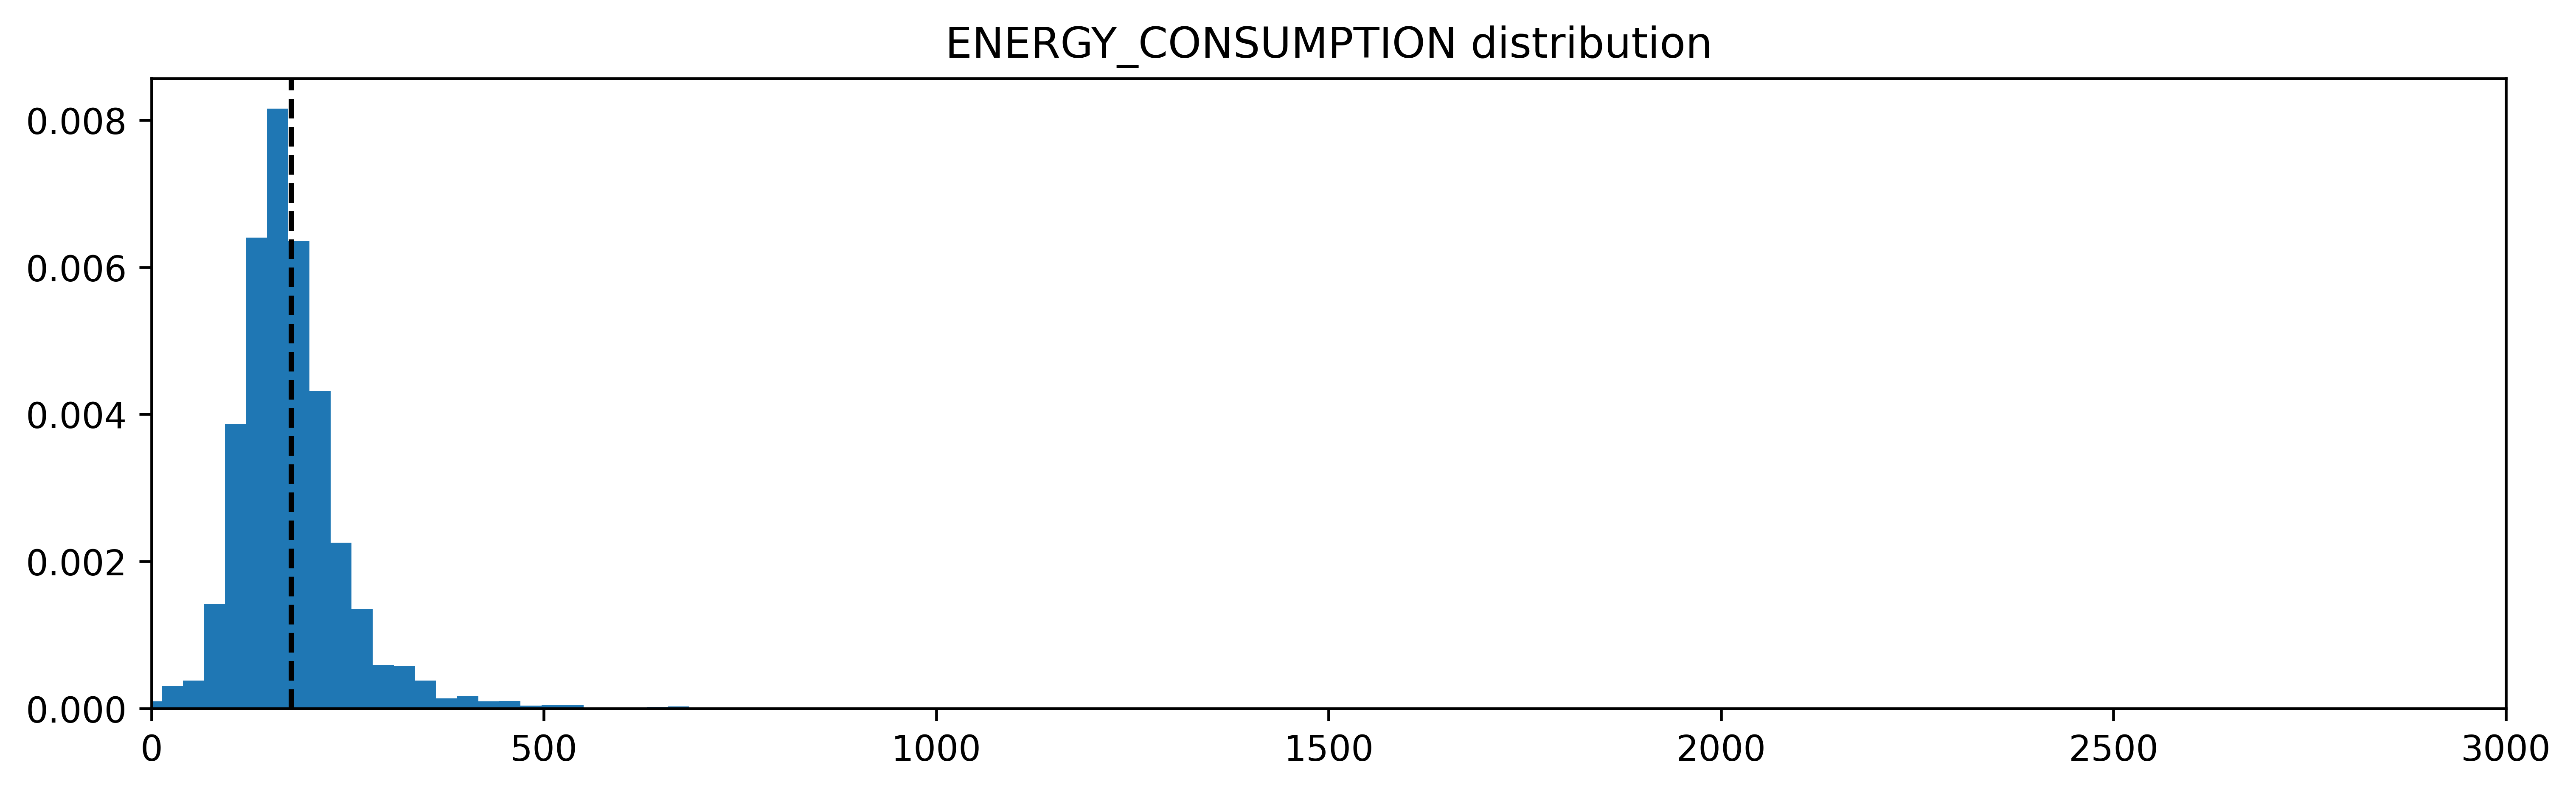

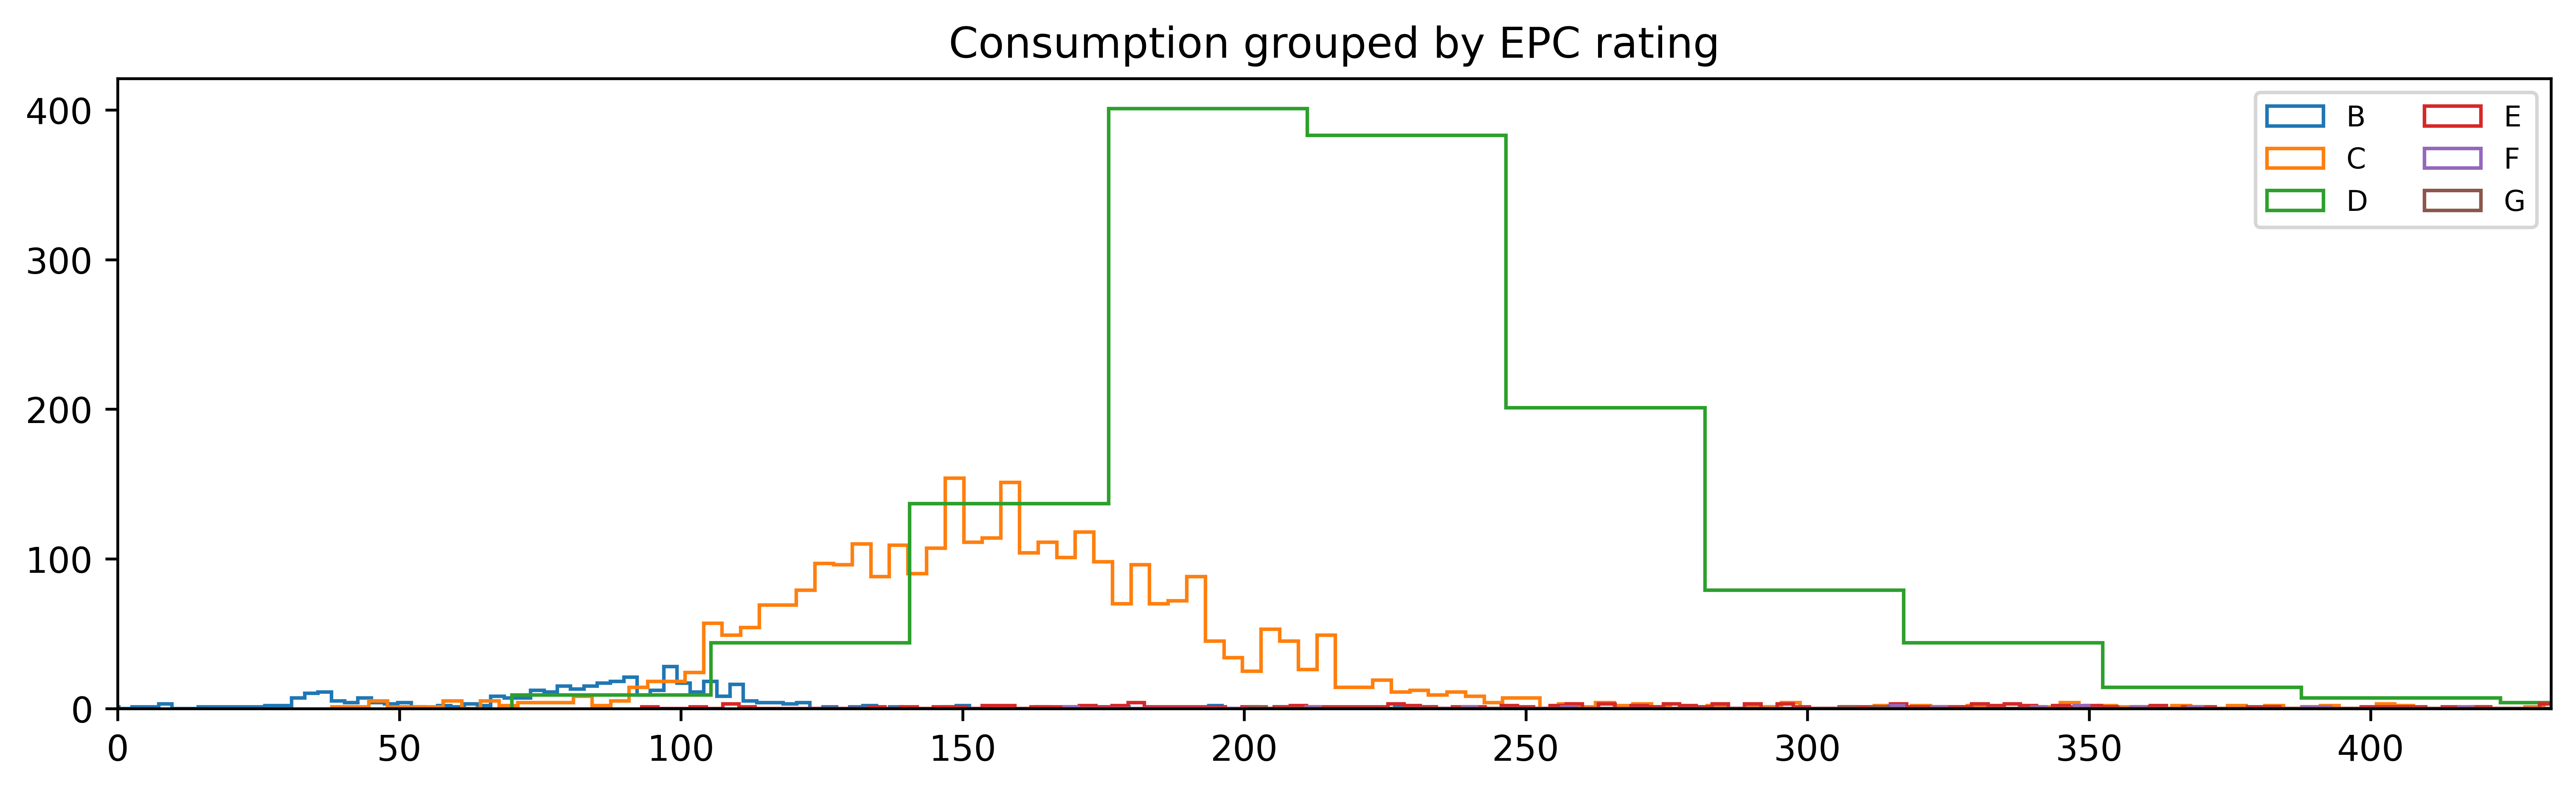

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_23920\2835056043.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = cats, showfliers=False)


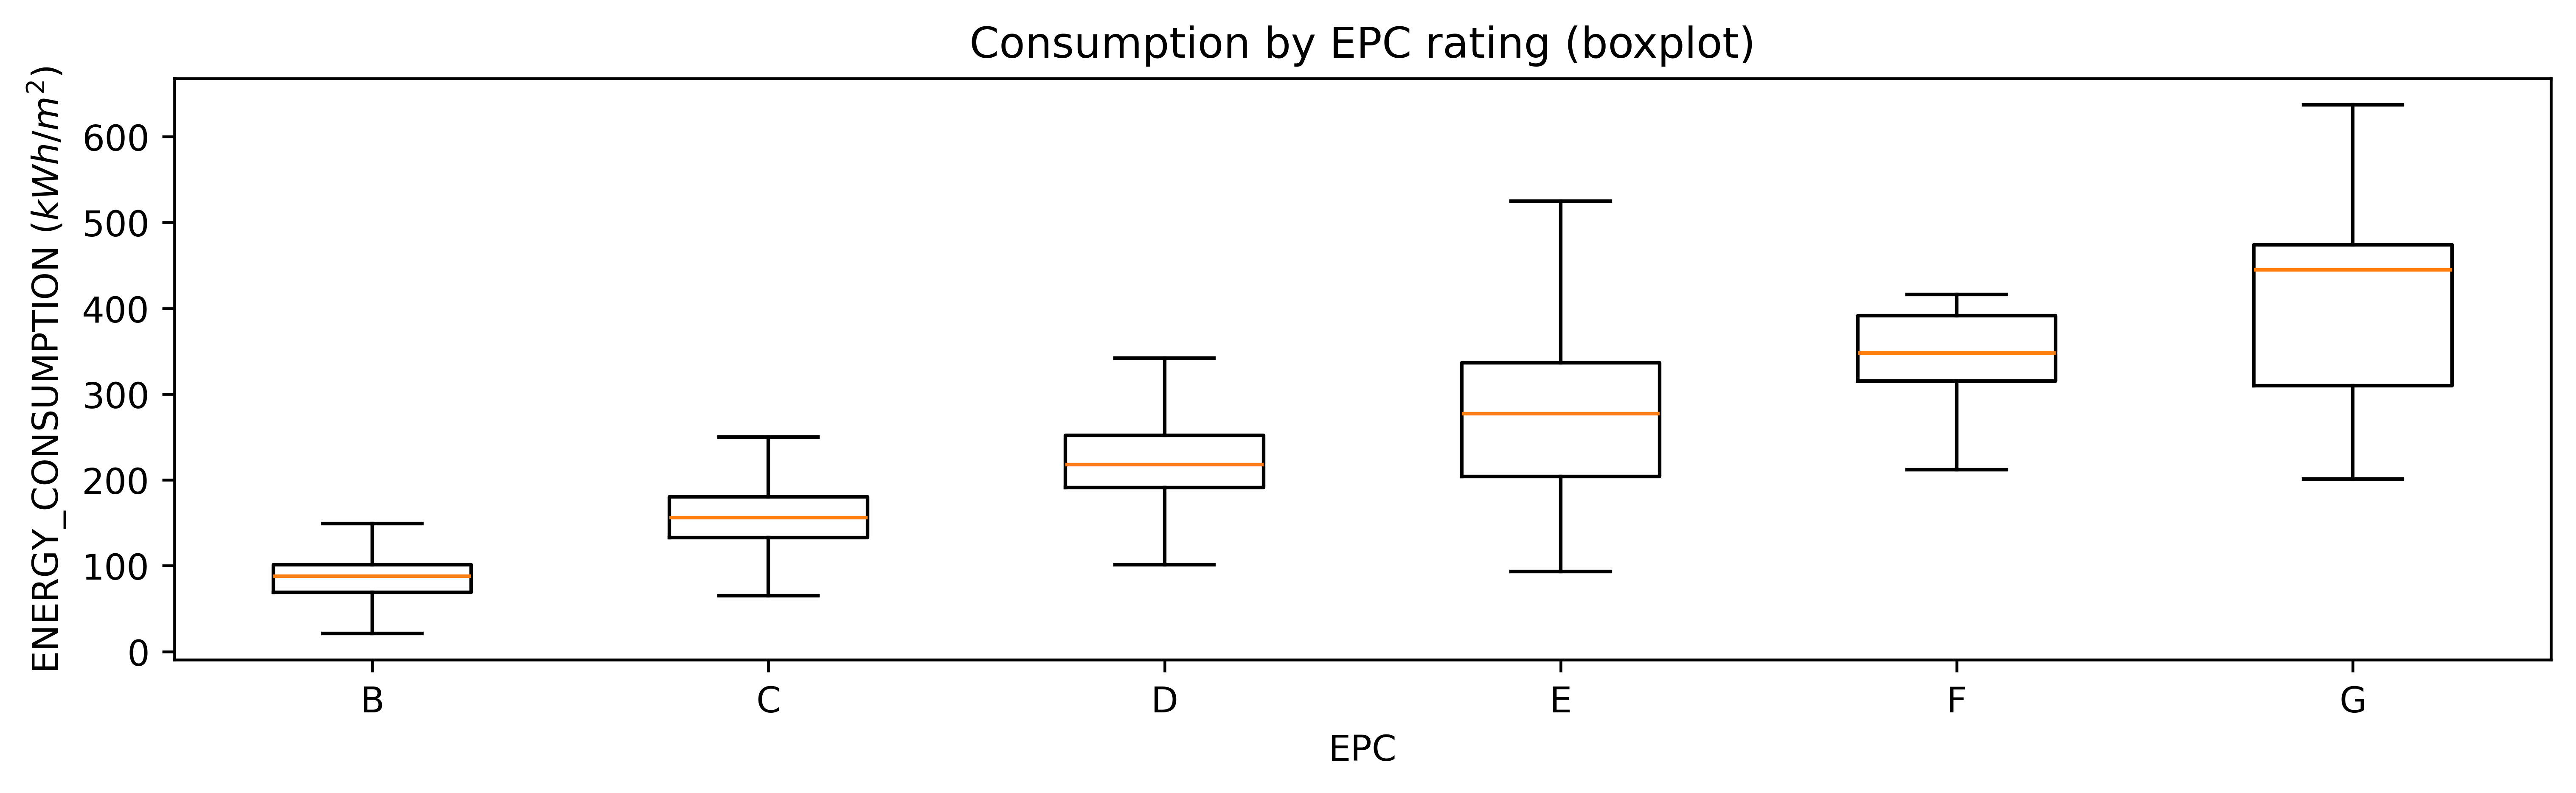

In [2]:
# Descriptive statistics
print(df['ENERGY_CONSUMPTION_CURRENT'].describe())
print(df['HEATING_COST_CURRENT'].describe())
print(df['CURRENT_ENERGY_RATING'].describe())

# Plot distribution
plt.figure()
plt.hist(df["ENERGY_CONSUMPTION_CURRENT"], bins=200, density=True)
plt.axvline(df["ENERGY_CONSUMPTION_CURRENT"].mean(), linestyle="--", color = 'black')
plt.xlim(0, 3000)
plt.title("ENERGY_CONSUMPTION distribution")
plt.show()


# EPC rating counts
plt.figure()
for k, g in df.groupby("CURRENT_ENERGY_RATING"):
    plt.hist(g["ENERGY_CONSUMPTION_CURRENT"], bins=150, histtype="step", label=str(k))
plt.xlim(0, df["ENERGY_CONSUMPTION_CURRENT"].quantile(0.99))
plt.title("Consumption grouped by EPC rating")
plt.legend(ncol=2, fontsize=8)
plt.show()

# Boxplot by EPC
plt.figure()
cats = sorted(df["CURRENT_ENERGY_RATING"].dropna().unique())
data = [df.loc[df["CURRENT_ENERGY_RATING"] == c, "ENERGY_CONSUMPTION_CURRENT"].values for c in cats]
plt.boxplot(data, labels = cats, showfliers=False)
plt.title("Consumption by EPC rating (boxplot)")
plt.xlabel("EPC")
plt.ylabel("ENERGY_CONSUMPTION $(kWh/m^2)$")
plt.show()

### Which factor drives energy consumption?

Your task is to assess which factor affects ```ENERGY_CONSUMPTION_CURRENT``` the most. You may use any descriptive or predictive method that consider appropriate. A few useful tips:
- Focus on the following list of features: ```['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA', 'WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 
                    'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'PROPERTY_TYPE', 'BUILT_FORM']```.
- Note that ```'CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA', 'WALLS_ENERGY_EFF'``` are numerical features, whereas the rest need to be encoded either as categorical or as ordinal features.
- There multiple ways to tackle this problem. For instance, you can apply linear regression analysis and conduct statistical tests. Alternatively, you can train predictive machine learning (ML) models and calculate relevant feature importance metrics, e.g., Shapley values.

In [3]:
target_variable = 'ENERGY_CONSUMPTION_CURRENT'
feature_list = ['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA',
            'WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'PROPERTY_TYPE', 'BUILT_FORM']

Y = df[target_variable]
X = df[feature_list]

for c in ['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'PROPERTY_TYPE', 'BUILT_FORM']:
    print(f'Feature: {c}')
    print(f'Categories: {X[c].unique()}')

Feature: WALLS_ENERGY_EFF
Categories: ['Poor' 'Good' 'Average' 'Very Poor' 'Very Good']
Feature: MAINHEAT_ENERGY_EFF
Categories: ['Good' 'Average' 'Very Poor' 'Poor' 'Very Good']
Feature: LIGHTING_ENERGY_EFF
Categories: ['Good' 'Average' 'Poor' 'Very Poor' 'Very Good']
Feature: HOT_WATER_ENERGY_EFF
Categories: ['Good' 'Average' 'Very Poor' 'Poor' 'Very Good']
Feature: PROPERTY_TYPE
Categories: ['Flat' 'Maisonette' 'House' 'Bungalow']
Feature: BUILT_FORM
Categories: ['Not Recorded' 'Mid-Terrace' 'Semi-Detached' 'End-Terrace'
 'Enclosed End-Terrace' 'Enclosed Mid-Terrace' 'Detached']


### Solution: Tree-based regression + Permutation Importance

We approach this problem using an ML predictor and estimating the importance of each feature. For this example, we select the ```ExtraTreesRegressor``` predictor from the ```sklearn``` library and estimate the [Permutation Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) metric, which is a modeling inspection method that works with any trained predictor. An illustrative example and explanation can be found [here](https://scikit-learn.org/stable/modules/permutation_importance.html). In short, given a trained model, each feature (column) observation is randomly shuffled (permutated) and predictive performance is evaluated on a hold-out set. The shuffling process resembles adding noise and renders each feature effectively useless; the expected decrease in predictive accuracy is a good proxy for the importance of each feature.

The code below implements the following steps:
- Features are seperated into numerical, categorical, and ordinal features. Categorical features are one-hot encoded using ```OneHotEncoder``` and ordinal features are encoded using ```OrdinalEncoder```.
- To streamline the preprocessing, a ```ColumnTransformer``` and a ```Pipeline``` object are created.
- Data are split into train/test set and the ExtraTree regressor is trained.
- The Permutation Importance method is applied.

Tree-based methods estimate an internal feature importance metric during training, based on expected error reduction when splitting an internal node, which is plotted as well.  However, this metric is known to be biased. Comparing the two plots, we observe that the most important feature differs from the one obtained using the Permutation Importance metric.

MSE: 785.2822113812963
RMSE: 28.022887277746673
MAE: 13.71489484848485


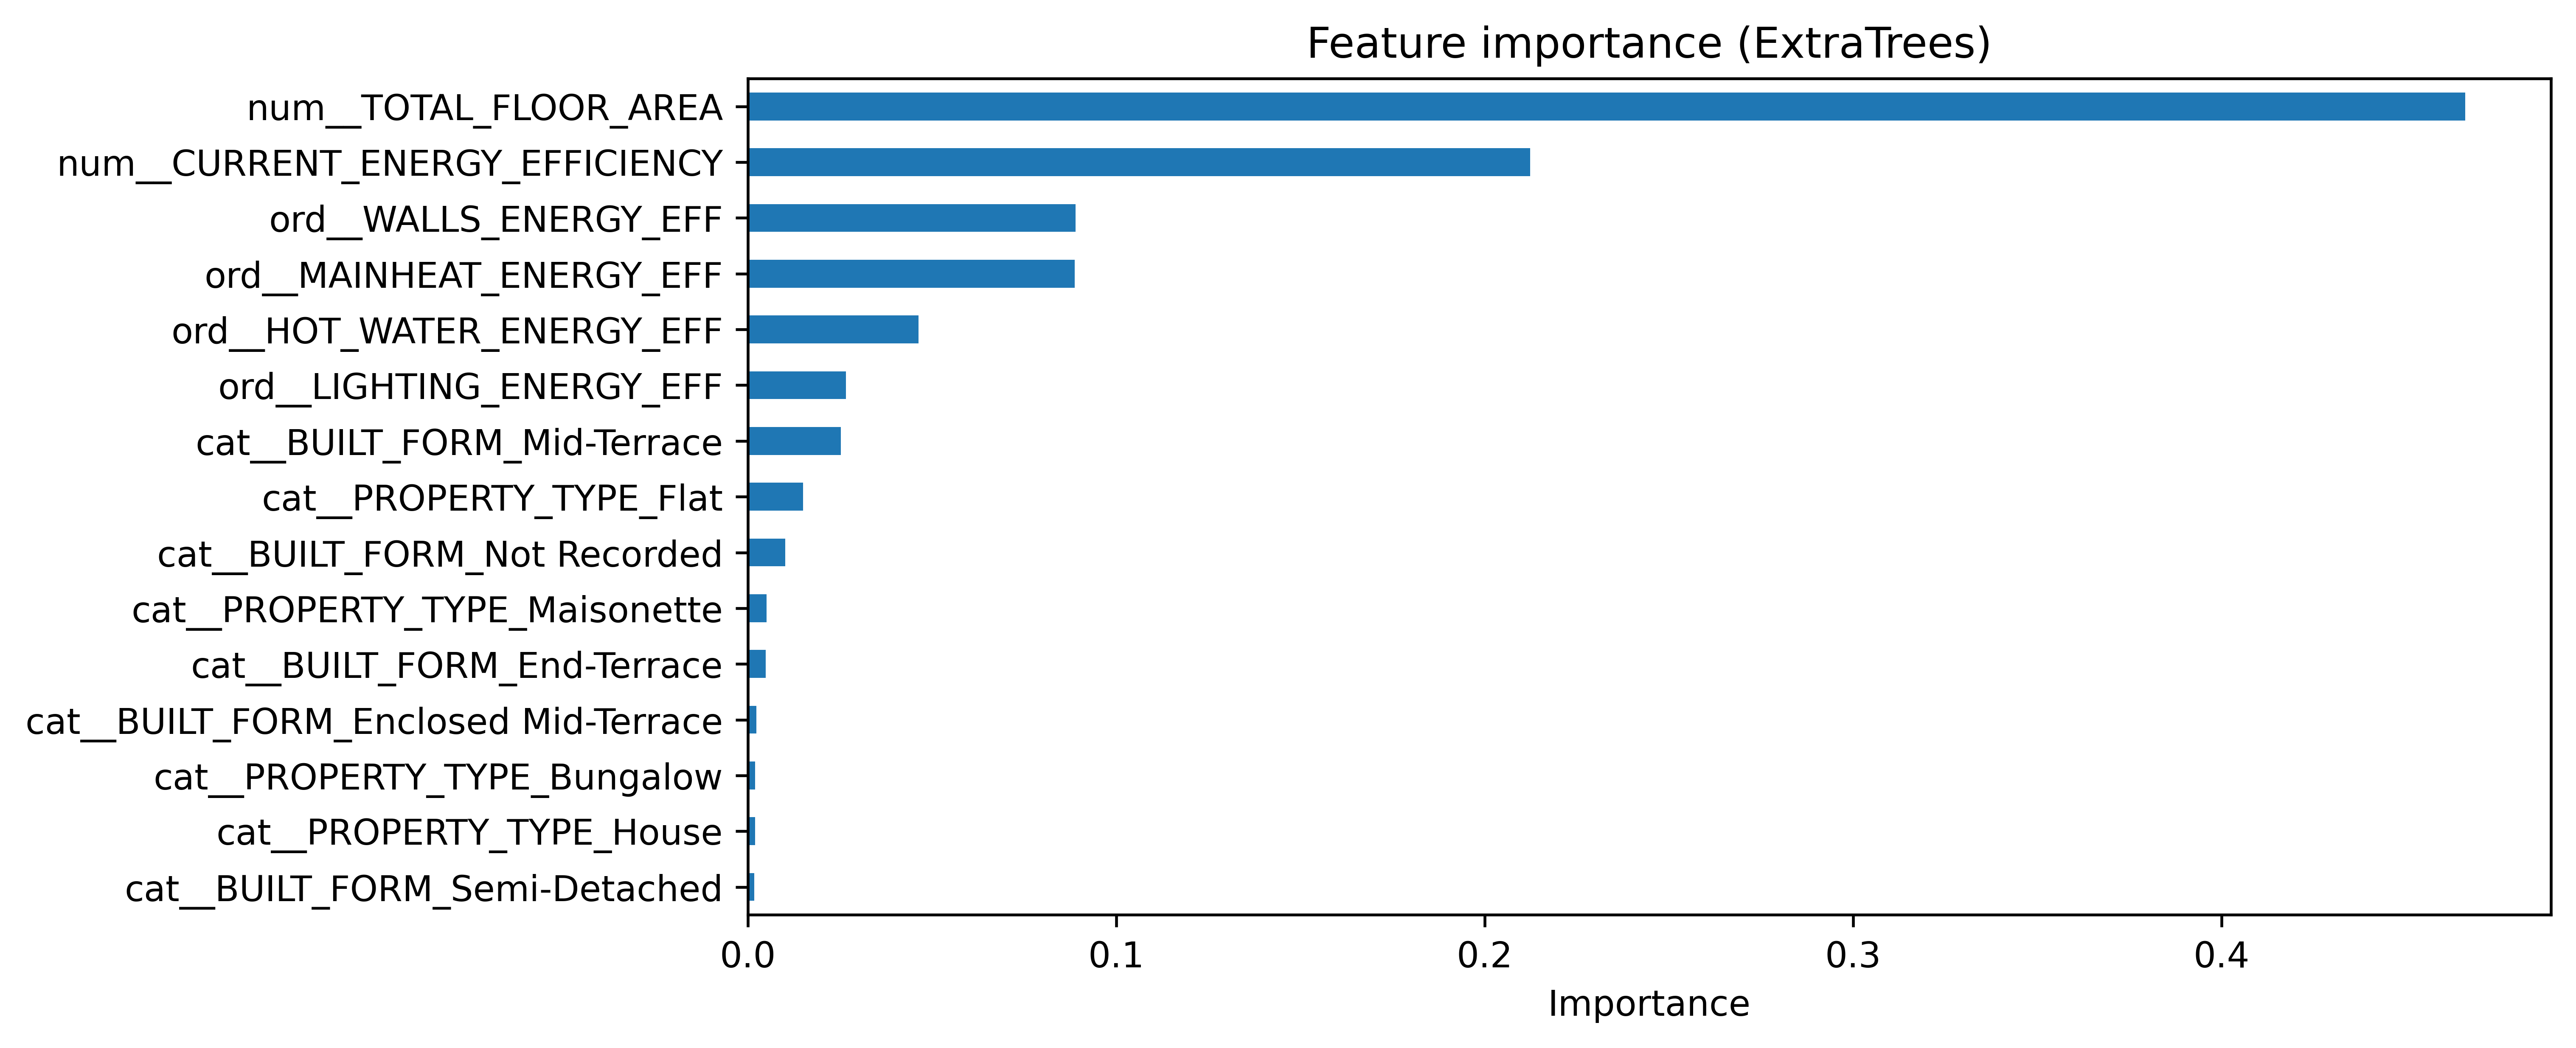

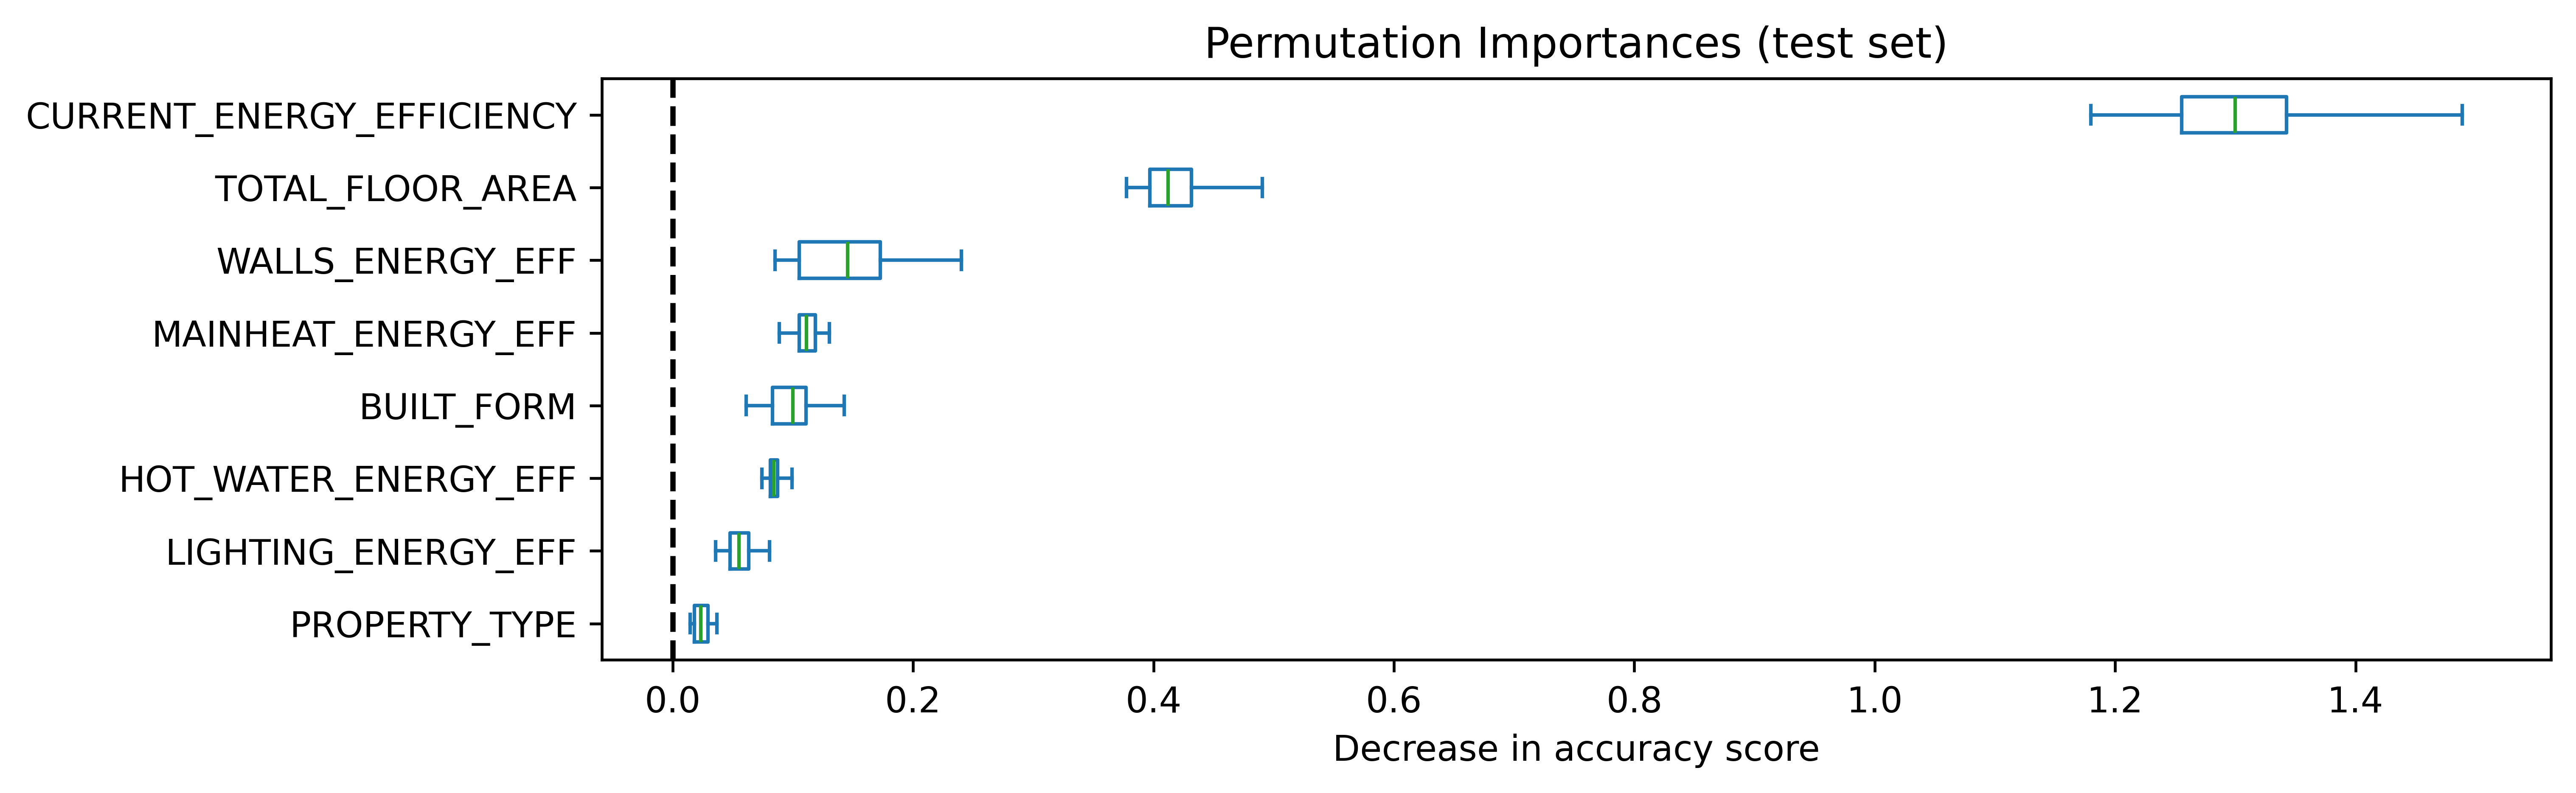

In [4]:
#%% Step 1: Pre-process and fit regression model

# Load libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance

target_variable = 'ENERGY_CONSUMPTION_CURRENT'
feature_list = ['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA',
            'WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'PROPERTY_TYPE', 'BUILT_FORM']

# further seperate features into numerical, categorical, and ordinal

numerical_features = ['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA']
ordinal_features = ['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 
                    'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF']
categorical_features = ['PROPERTY_TYPE', 'BUILT_FORM']

Y = df[target_variable]
X = df[feature_list]

# Training/ test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42)


# ------------------
# Preprocessing
# ------------------

categories_list = [['Bungalow', 'Flat', 'House', 'Maisonette'], 
                  ['Not Recorded', 'Detached', 'Enclosed End-Terrace', 'Enclosed Mid-Terrace','End-Terrace', 'Mid-Terrace', 'Semi-Detached']]

ord_list =   [['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'], 
              ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'],
              ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'], 
              ['Very Poor', 'Poor', 'Average', 'Good', 'Very Good']]

# create preprocessor that implements one-hot and ordinal encoding
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                  ("ord", OrdinalEncoder(categories = ord_list), ordinal_features),
                  ("num", "passthrough", numerical_features),])


# ExtraTree Model pipeline
et_model = Pipeline(
    steps=[("preprocess", preprocessor), ("regressor", ExtraTreesRegressor()),])

et_model.fit(train_X, train_Y)
y_et_pred = et_model.predict(test_X)

# evaluate accuracy 
_, _ = accuracy_metrics(test_Y.values, y_et_pred)

# plt.plot(test_current_Y.values[:1000])
# plt.plot(y_et_pred[:1000])
# plt.show()

# Feature importance (default estimation in tree-based algorithms)
# get feature names after one-hot encoding
feature_names = et_model.named_steps["preprocess"].get_feature_names_out()
importances = et_model.named_steps["regressor"].feature_importances_

fi = pd.Series(importances, index = feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 4))
fi.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature importance (ExtraTrees)")
plt.xlabel("Importance")
plt.show()

# Permutation importance
r = permutation_importance(et_model, test_X, test_Y, n_repeats=30, random_state=0)
sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame( r.importances[sorted_importances_idx].T, columns = X.columns[sorted_importances_idx],)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
plt.show()
